# Chapter 5 - Putting It All Together

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Bitcoin & Ethereum

### A Dog on a Leash? (Part 1)

The Heating Oil and Natural Gas prices are pre-loaded in DataFrames HO and NG. 
First, plot both price series, which look like random walks. Then plot the 
difference between the two series, which should look more like a mean reverting 
series (to put the two series in the same units, we multiply the heating oil 
prices, in \\$/gallon, by 7.25, which converts it to \\$/millionBTU, which is the 
same units as Natural Gas).

The data for continuous futures (each contract has to be spliced together in a 
continuous series as contracts expire) was obtained from Quandl.

In [8]:
HO = pd.read_excel('data/HO.xlsx')

HO.head()

,Date,Close
0,2005-12-30,1.7280
1,2005-12-29,1.7030
2,2005-12-28,1.6825
3,2005-12-27,1.6370
4,2005-12-23,1.7053


In [9]:
HO = HO.set_index('Date')

HO.head()

,Close
Date,
2005-12-30,1.7280
2005-12-29,1.7030
2005-12-28,1.6825
2005-12-27,1.6370
2005-12-23,1.7053


In [10]:
NG = pd.read_excel('data/NG.xlsx')

NG

,Date,Close
0,2005-12-30,11.225
1,2005-12-29,11.223
2,2005-12-28,11.431
3,2005-12-27,11.022
4,2005-12-23,12.283
...,...,...
3749,1991-01-08,1.786
3750,1991-01-07,1.785
3751,1991-01-04,1.743
3752,1991-01-03,1.782


In [11]:
NG = NG.set_index('Date')

NG.head()

,Close
Date,
2005-12-30,11.225
2005-12-29,11.223
2005-12-28,11.431
2005-12-27,11.022
2005-12-23,12.283


In [12]:
NG.tail()

,Close
Date,
1991-01-08,1.786
1991-01-07,1.785
1991-01-04,1.743
1991-01-03,1.782
1991-01-02,1.832


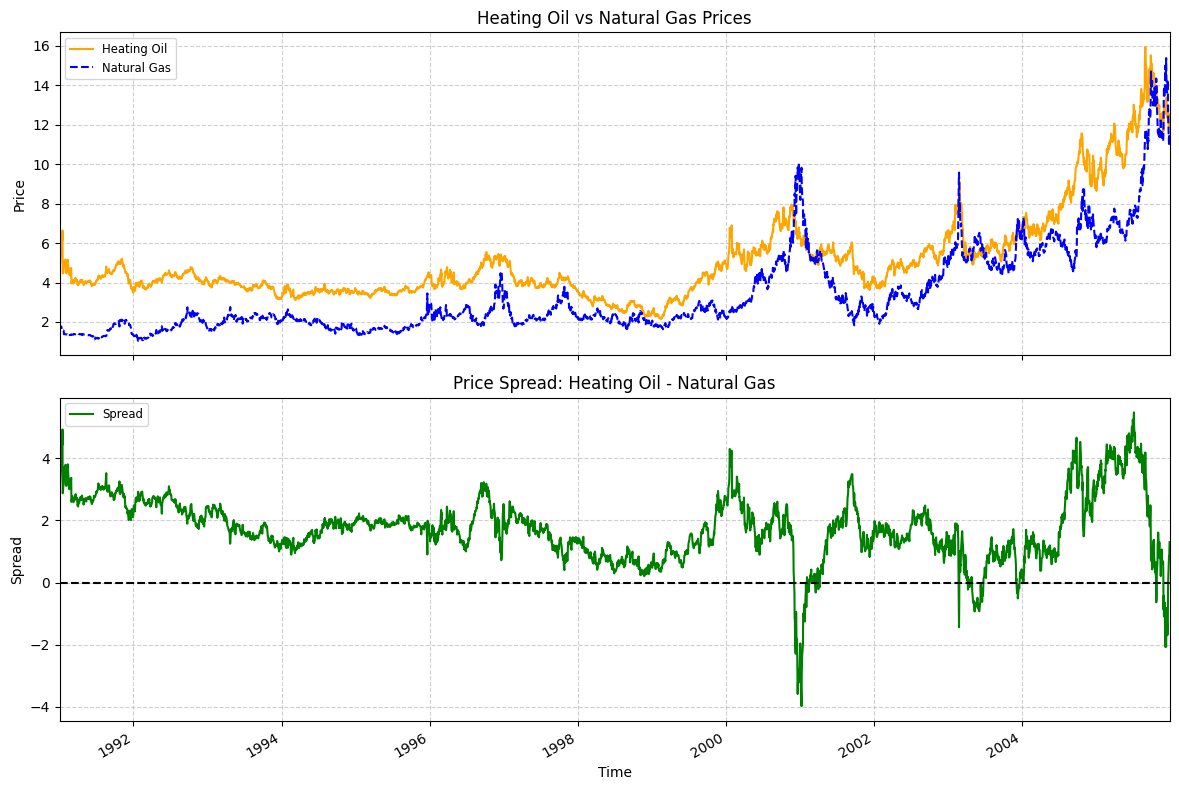

In [13]:
# Create a figure with 2 subplots stacked vertically
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# Plot Heating Oil and Natural Gas Prices
axes[0].plot(7.25 * HO, color='orange', linestyle='-', label='Heating Oil')
axes[0].plot(NG, 'b--', label='Natural Gas')
axes[0].set_ylabel('Price')
axes[0].set_title('Heating Oil vs Natural Gas Prices')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend(loc='best', fontsize='small')
axes[0].set_xlim(pd.to_datetime('1991-01-02'), pd.to_datetime('2005-12-30'))

# Plot the Spread
axes[1].plot(7.25 * HO - NG, 'g-', label='Spread')
axes[1].set_ylabel('Spread')
axes[1].set_xlabel('Time')
axes[1].set_title('Price Spread: Heating Oil - Natural Gas')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].axhline(y=0, linestyle='--', color='k')
axes[1].legend(loc='best', fontsize='small')
axes[1].set_xlim(pd.to_datetime('1991-01-02'), pd.to_datetime('2005-12-30'))

# Format x-axis
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


### A Dog on a Leash? (Part 2)

    To verify that Heating Oil and Natural Gas prices are cointegrated, First apply  the Dickey-Fuller test separately to show they are random walks. Then apply the  test to the difference, which should strongly reject the random walk hypothesis.  The Heating Oil and Natural Gas prices are pre-loaded in DataFrames HO and NG.

In [15]:
print('============ HO ============')

# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(HO['Close'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

============ HO ============
ADF Statistic: -3.202663396386017
p-value: 0.019831028071628197

p-value < alpha; Ha: Stationary


In [16]:
print('============ NG ============')

# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(NG['Close'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

============ NG ============
ADF Statistic: -3.670530843881677
p-value: 0.004547284956542518

p-value < alpha; Ha: Stationary


In [17]:
print('============ Spread ============')

# Spread Adjust
result_spread = 7.25 * HO['Close'] - NG['Close']

# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(result_spread)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

============ Spread ============
ADF Statistic: -4.619541383833968
p-value: 0.000118870518273535

p-value < alpha; Ha: Stationary


### Are Bitcoin and Ethereum Cointegrated?

    Cointegration involves two steps: regressing one time series on the other to  get the cointegration vector, and then perform an ADF test on the residuals of  the regression. In the last example, there was no need to perform the first  step since we implicitly assumed the cointegration vector was (1,−1). In other  words, we took the difference between the two series (after doing a units  conversion). Here, you will do both steps.

    You will regress the value of one cryptocurrency, bitcoin (BTC), on another  cryptocurrency, ethereum (ETH). If we call the regression coefficient b, then  the cointegration vector is simply (1,−b). Then perform the ADF test on BTC −b  ETH. Bitcoin and Ethereum prices are pre-loaded in DataFrames BTC and ETH.

In [19]:
BIT = pd.read_csv('data/Bitcoin.csv', sep=';', quotechar='"')

BIT.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2025-03-12T00:00:00.000Z,2025-03-12T23:59:59.999Z,2025-03-12T12:31:00.000Z,2025-03-12T15:09:00.000Z,2781,82857.378372,84358.577462,80635.249235,83722.361952,4.035348e+10,1.660115e+12,2025-03-12T23:59:59.999Z
1,2025-03-11T00:00:00.000Z,2025-03-11T23:59:59.999Z,2025-03-11T19:09:00.000Z,2025-03-11T00:52:00.000Z,2781,78523.871544,83577.755959,76624.252490,82862.208181,5.470284e+10,1.643251e+12,2025-03-11T23:59:59.999Z
2,2025-03-10T00:00:00.000Z,2025-03-10T23:59:59.999Z,2025-03-10T09:25:00.000Z,2025-03-10T19:05:00.000Z,2781,80597.149784,83955.926252,77420.592186,78532.001808,5.406110e+10,1.558444e+12,2025-03-10T23:59:59.999Z
3,2025-03-09T00:00:00.000Z,2025-03-09T23:59:59.999Z,2025-03-09T01:02:00.000Z,2025-03-09T23:08:00.000Z,2781,86154.305891,86471.130163,80052.486979,80601.041311,3.089935e+10,1.598205e+12,2025-03-09T23:59:59.999Z
4,2025-03-08T00:00:00.000Z,2025-03-08T23:59:59.999Z,2025-03-08T00:54:00.000Z,2025-03-08T01:35:00.000Z,2781,86742.652990,86847.267594,85247.484188,86154.593210,1.820612e+10,1.708771e+12,2025-03-08T23:59:59.999Z


In [20]:
# Keep only 'timeClose' and 'close' columns
BIT = BIT[['timeClose', 'close']]

# Display the first few rows to verify
BIT.head()

,timeClose,close
0,2025-03-12T23:59:59.999Z,83722.361952
1,2025-03-11T23:59:59.999Z,82862.208181
2,2025-03-10T23:59:59.999Z,78532.001808
3,2025-03-09T23:59:59.999Z,80601.041311
4,2025-03-08T23:59:59.999Z,86154.593210


In [21]:
BIT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timeClose  364 non-null    object 
 1   close      364 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [22]:
BIT.tail()

,timeClose,close
359,2024-03-18T23:59:59.999Z,67548.591566
360,2024-03-17T23:59:59.999Z,68390.622803
361,2024-03-16T23:59:59.999Z,65315.117474
362,2024-03-15T23:59:59.999Z,69403.771832
363,2024-03-14T23:59:59.999Z,71396.589892


In [23]:
# Convert 'timeClose' to datetime and keep only the date
BIT['timeClose'] = pd.to_datetime(BIT['timeClose']).dt.date

# Round 'close' column to 2 decimal places
BIT['close'] = BIT['close'].round(2)

# Display the first rows
BIT.head()

,timeClose,close
0,2025-03-12,83722.36
1,2025-03-11,82862.21
2,2025-03-10,78532.00
3,2025-03-09,80601.04
4,2025-03-08,86154.59


In [24]:
# Convert the date index to datetime
BIT = BIT.set_index('timeClose')
BIT.index = pd.to_datetime(BIT.index)

BIT.head()

,close
timeClose,
2025-03-12,83722.36
2025-03-11,82862.21
2025-03-10,78532.00
2025-03-09,80601.04
2025-03-08,86154.59


In [25]:
ETH = pd.read_csv('data/Ethereum.csv', sep=';', quotechar='"')

ETH.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2025-03-12T00:00:00.000Z,2025-03-12T23:59:59.999Z,2025-03-12T09:06:00.000Z,2025-03-12T15:09:00.000Z,2781,1919.664785,1954.571114,1832.019028,1908.982685,2.289887e+10,2.302449e+11,2025-03-12T23:59:59.999Z
1,2025-03-11T00:00:00.000Z,2025-03-11T23:59:59.999Z,2025-03-11T18:55:00.000Z,2025-03-11T00:52:00.000Z,2781,1859.777676,1961.797777,1760.941791,1919.844949,3.089839e+10,2.315248e+11,2025-03-11T23:59:59.999Z
2,2025-03-10T00:00:00.000Z,2025-03-10T23:59:59.999Z,2025-03-10T09:25:00.000Z,2025-03-10T19:01:00.000Z,2781,2015.430418,2150.706287,1812.766875,1861.151391,3.500507e+10,2.242981e+11,2025-03-10T23:59:59.999Z
3,2025-03-09T00:00:00.000Z,2025-03-09T23:59:59.999Z,2025-03-09T01:08:00.000Z,2025-03-09T23:07:00.000Z,2781,2201.708664,2210.313615,1991.193449,2015.509109,1.610396e+10,2.430656e+11,2025-03-09T23:59:59.999Z
4,2025-03-08T00:00:00.000Z,2025-03-08T23:59:59.999Z,2025-03-08T19:50:00.000Z,2025-03-08T01:35:00.000Z,2781,2139.797852,2232.327159,2107.727997,2201.510222,1.053320e+10,2.655255e+11,2025-03-08T23:59:59.999Z


In [26]:
# Keep only 'timeClose' and 'close' columns
ETH = ETH[['timeClose', 'close']]

# Convert 'timeClose' to datetime and keep only the date
ETH['timeClose'] = pd.to_datetime(ETH['timeClose']).dt.date

In [27]:
# Round 'close' column to 2 decimal places
ETH['close'] = ETH['close'].round(2)

# Convert the date index to datetime
ETH = ETH.set_index('timeClose')
ETH.index = pd.to_datetime(ETH.index)

# Display first rows
ETH.head()

,close
timeClose,
2025-03-12,1908.98
2025-03-11,1919.84
2025-03-10,1861.15
2025-03-09,2015.51
2025-03-08,2201.51


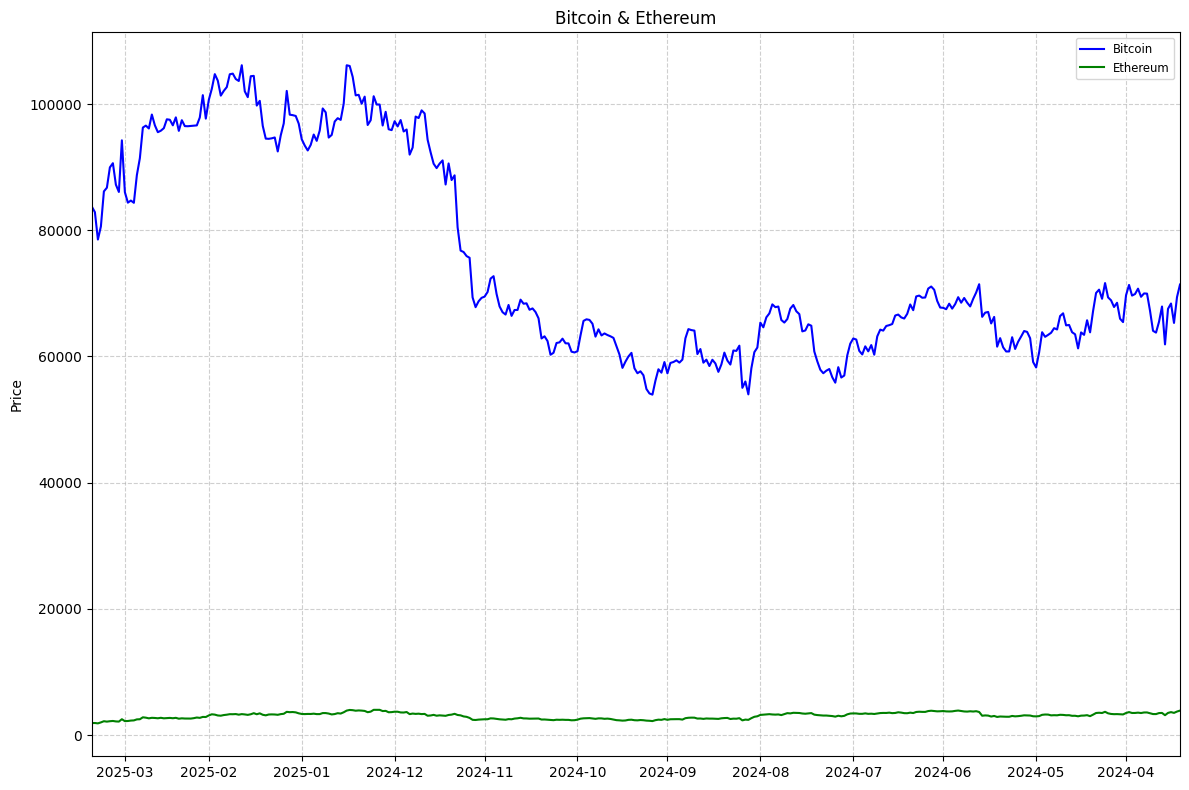

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(BIT['close'], color='blue', linestyle='-', label='Bitcoin')
ax.plot(ETH['close'], color='green', linestyle='-', label='Ethereum')
ax.set_ylabel('Price')
ax.set_title('Bitcoin & Ethereum')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(loc='best', fontsize='small')
ax.set_xlim(pd.to_datetime('2025-03-12'), pd.to_datetime('2024-03-14'))

plt.tight_layout()
plt.show()

In [29]:
# Add constant for intercept
ETH = sm.add_constant(ETH)

# Perform OLS regression
result = sm.OLS(BIT, ETH).fit()

# Get parameters
intercept, slope = result.params

# Display the full summary of the regression results
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     31.01
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           5.01e-08
Time:                        14:42:42   Log-Likelihood:                -4019.2
No. Observations:                 364   AIC:                             8042.
Df Residuals:                     362   BIC:                             8050.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.703e+04   5080.819      9.256      0.0

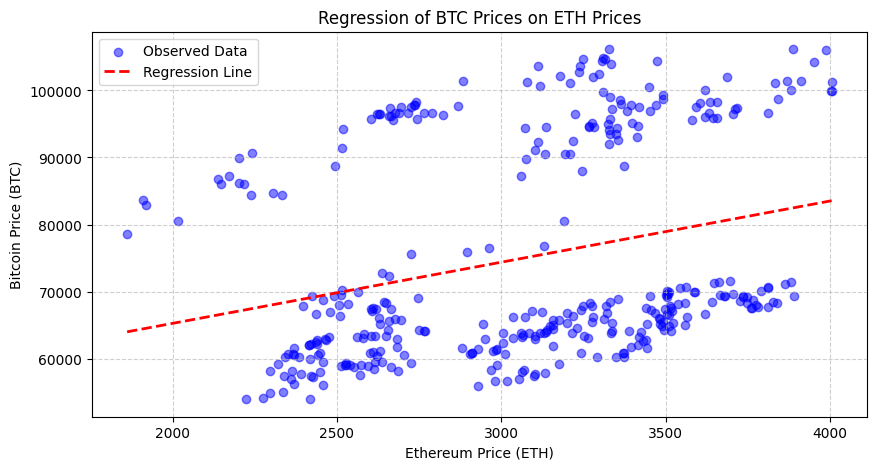

In [30]:
# Plot the data and regression line
fig, ax = plt.subplots(figsize=(10, 5))

# Scatter plot of the data
ax.scatter(ETH['close'], BIT['close'], color="blue", alpha=0.5, label="Observed Data")

# Plot regression line
ETH_range = np.linspace(ETH['close'].min(), ETH['close'].max(), 100)
BTC_pred = intercept + slope * ETH_range
ax.plot(ETH_range, BTC_pred, color="red", linestyle="--", linewidth=2, label="Regression Line")

# Formatting
ax.set_xlabel("Ethereum Price (ETH)")
ax.set_ylabel("Bitcoin Price (BTC)")
ax.set_title("Regression of BTC Prices on ETH Prices")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)

# Show the graph
plt.show()

In [31]:
slope

9.11794177956269

In [32]:
# Compute ADF
b = slope                                    # intercept, slope = result.params
residuals = BIT['close'] - b*ETH['close']    # computes the residuals from the regression

# Run the Augmented Dickey-Fuller (ADF) test with the residuals
adf_result = adfuller(residuals)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -1.2889847057598798
p-value: 0.6341966357564768

p-value > alpha; H0: Not Stationary


    If p-value < 0.05 → Reject H0: Residuals are stationary → BTC and ETH are cointegrated.
    
    If p-value ≥ 0.05 → Fail to reject H0: Residuals are non-stationary → No cointegration.

# Climate Change

### Is Temperature a Random Walk (with Drift)?

    An ARMA model is a simplistic approach to forecasting climate changes, but it illustrates many of the topics covered in this class.

    The DataFrame temp_NY contains the average annual temperature in Central Park, NY from 1870-2016 (NOAA). Plot the data and test whether it follows a random walk (with drift).

In [36]:
temp_NY = pd.read_excel('data/temp_NY.xlsx')

temp_NY.head()

,DATE,TAVG
0,1870-01-01,53.8
1,1871-01-01,51.3
2,1872-01-01,51.3
3,1873-01-01,50.9
4,1874-01-01,51.3


In [37]:
temp_NY = temp_NY.set_index('DATE')
temp_NY.index = pd.to_datetime(temp_NY.index)

temp_NY.head()

,TAVG
DATE,
1870-01-01,53.8
1871-01-01,51.3
1872-01-01,51.3
1873-01-01,50.9
1874-01-01,51.3


In [38]:
temp_NY.tail()

,TAVG
DATE,
2012-01-01,57.3
2013-01-01,55.3
2014-01-01,54.4
2015-01-01,56.7
2016-01-01,57.2


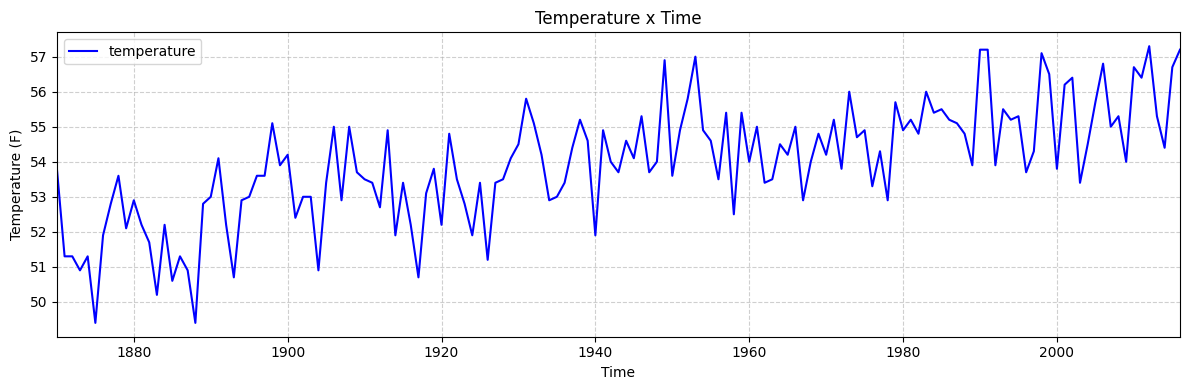

In [39]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(temp_NY['TAVG'], color='blue', linestyle='-', label='temperature')
ax.set_ylabel('Temperature (F)')
ax.set_xlabel('Time')
ax.set_title('Temperature x Time')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(loc=2)
ax.set_xlim(pd.to_datetime('1870-01-01'), pd.to_datetime('2016-01-01'))

plt.tight_layout()
plt.show()

In [40]:
# Run the Augmented Dickey-Fuller (ADF) test with the residuals
adf_result = adfuller(temp_NY['TAVG'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -1.3978761406265454
p-value: 0.5832938987871099

p-value > alpha; H0: Not Stationary


### Getting "Warmed" Up: Look at Autocorrelations

Since the temperature series, temp_NY, is a random walk with drift, take first  differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

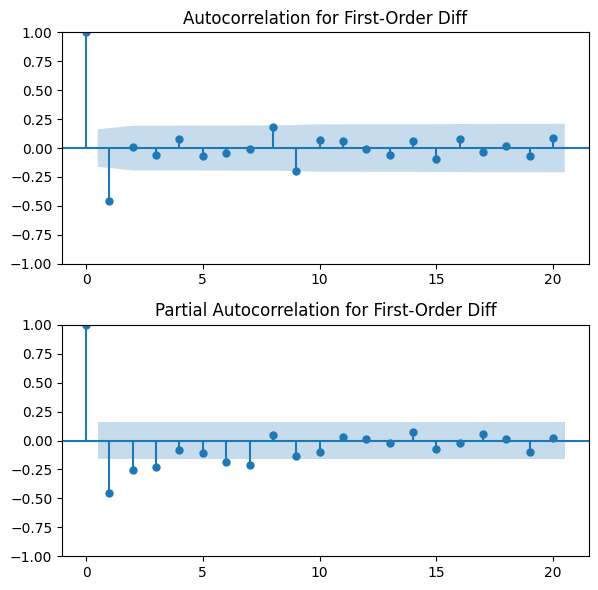

In [42]:
# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()


# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1, figsize=(6,6)) 

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation for First-Order Diff')  

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation for First-Order Diff')

plt.tight_layout() 
plt.show()

### Which ARMA Model is Best?

Recall from Chapter 3 that the Akaike Information Criterion (AIC) can be used 
to compare models with different numbers of parameters. It measures 
goodness-of-fit, but places a penalty on models with more parameters to 
discourage overfitting. Lower AIC scores are better.

Fit the temperature data to an AR(1), AR(2), and ARMA(1,1) and see which model 
is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have 
one more parameter than the AR(1) has.

The annual change in temperature is in a DataFrame chg_temp

In [44]:
chg_temp = pd.read_excel('data/chg_temp.xlsx')

chg_temp.head()

,DATE,TAVG
0,1871-01-01,-2.5
1,1872-01-01,0.0
2,1873-01-01,-0.4
3,1874-01-01,0.4
4,1875-01-01,-1.9


In [45]:
chg_temp = chg_temp.set_index('DATE')
chg_temp.index = pd.to_datetime(chg_temp.index)

chg_temp.head()

,TAVG
DATE,
1871-01-01,-2.5
1872-01-01,0.0
1873-01-01,-0.4
1874-01-01,0.4
1875-01-01,-1.9


In [46]:
chg_temp.tail()

,TAVG
DATE,
2012-01-01,0.9
2013-01-01,-2.0
2014-01-01,-0.9
2015-01-01,2.3
2016-01-01,0.5


In [47]:
# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARIMA(chg_temp, order=(1, 0, 0))  # AR(1), MA(0), differencing(0)
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is:", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARIMA(chg_temp, order=(2, 0, 0))  # AR(2), MA(0), differencing(0)
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is:", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARIMA(chg_temp, order=(1, 0, 1))  # AR(1), MA(1), differencing(0)
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is:", res_arma11.aic)

The AIC for an AR(1) is: 510.53468987331075
The AIC for an AR(2) is: 501.9274123409136
The AIC for an ARMA(1,1) is: 469.0729191833501


    Best model among these three: ARMA(1,1) with the lowest AIC value.

### Don't Throw Out That Winter Coat Yet

Finally, you will forecast the temperature over the next 30 years using an 
ARMA(1,1) model, including confidence bands around that estimate. Keep in mind 
that the estimate of the drift will have a much bigger impact on long range 
forecasts than the ARMA parameters.

Earlier, you determined that the temperature data follows a random walk and you 
looked at first differencing the data. In this exercise, you will use the ARIMA 
module on the temperature data (before differencing), which is identical to 
using the ARMA module on changes in temperature, followed by taking cumulative 
sums of these changes to get the temperature forecast.

In [50]:
# Forecast temperatures using an ARIMA(1,1,1) model
mod = ARIMA(temp_NY, order=(1,1,1))
res = mod.fit()

# Print summary of the fitted model
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   TAVG   No. Observations:                  147
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -235.635
Date:                Thu, 13 Mar 2025   AIC                            477.269
Time:                        14:42:42   BIC                            486.220
Sample:                    01-01-1870   HQIC                           480.906
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0814      0.112      0.729      0.466      -0.137       0.300
ma.L1         -0.8662      0.058    -14.993      0.000      -0.979      -0.753
sigma2         1.4644      0.213      6.874      0.0

In [51]:
# Generate forecast
forecast = res.get_forecast(steps=10)     # Forecast next 10 steps
predicted_mean = forecast.predicted_mean  # Forecasted values
conf_int = forecast.conf_int()            # Confidence intervals

In [52]:
predicted_mean

2017-01-01    56.000394
2018-01-01    55.902743
2019-01-01    55.894794
2020-01-01    55.894146
2021-01-01    55.894094
2022-01-01    55.894090
2023-01-01    55.894089
2024-01-01    55.894089
2025-01-01    55.894089
2026-01-01    55.894089
Freq: YS-JAN, Name: predicted_mean, dtype: float64

In [53]:
conf_int

,lower TAVG,upper TAVG
2017-01-01,53.628605,58.372183
2018-01-01,53.476657,58.328828
2019-01-01,53.442308,58.347279
2020-01-01,53.417298,58.370995
2021-01-01,53.393259,58.394929
2022-01-01,53.369507,58.418672
2023-01-01,53.345981,58.442197
2024-01-01,53.322671,58.465507
2025-01-01,53.299571,58.488607
2026-01-01,53.276674,58.511504


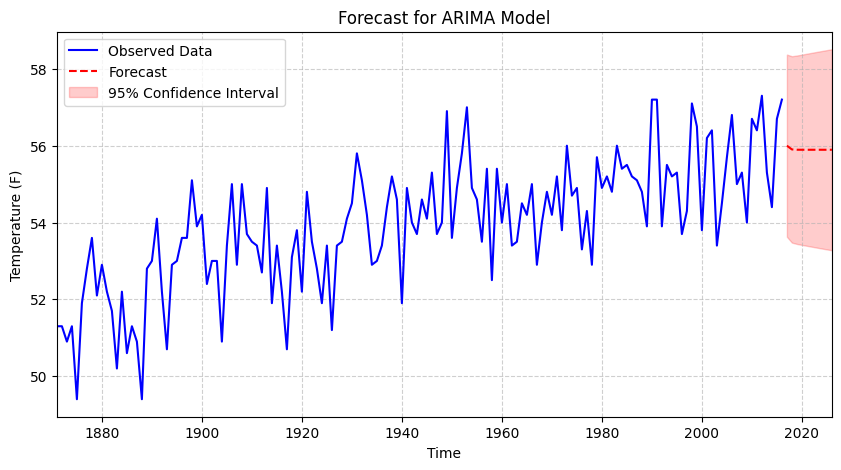

In [54]:
# Ensure forecast_index is properly formatted as a DatetimeIndex
forecast_index = pd.date_range(start=res.data.dates[-1], periods=11, freq='AS')[1:]  # Generate 10 future dates

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the original time series
ax.plot(res.data.dates, res.data.endog, label="Observed Data", color='blue')  # Ensure original data has correct x-axis

# Plot the forecast with datetime index
ax.plot(forecast_index, predicted_mean, label="Forecast", color='red', linestyle='--')

# Plot confidence intervals
ax.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], 
                color='red', alpha=0.2, label="95% Confidence Interval")

# Formatting
ax.set_xlabel("Time")
ax.set_ylabel("Temperature (F)")
ax.set_title("Forecast for ARIMA Model")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)

# Set x-axis limits correctly
ax.set_xlim(pd.Timestamp('1871-01-01'), pd.Timestamp('2026-01-01'))

# Show the plot
plt.show()